# 1- Train the models

In [4]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from get_utils import return_ignore, get_data, get_dir
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np
from tdr import build_tdr, project_onto_map, orth_wrt_map
import torch as th
import scipy.stats as stats
import plot as plot
from matplotlib.colors import ListedColormap




#%matplotlib qt
#%matplotlib widget
%matplotlib inline

# Directory info
This is the format that I use for generating directory when I train models. I use the network size of 128 for all analysis.

In [5]:
n_model = 40 # number of simulated networks
network_siz = 128
folder_name = f'Sim_fixed_{network_siz}'

# General things

You can specify a saving directory, basically the directory in which the figure can be saved.
The base directory is **hard-coded** in the current version of the code.


In [6]:
loss_type = 'lateral' # I chose lateral deviation as the loss function


phases = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}
labels = ['NF1','FF1','NF2','FF2']
palette_colors = {'FF1':(0,0.5,0),'FF2':(0.4,0.4,0.8),'NF1':(0,0,0),'NF2':(0,0,0)}



fontsize_label = 7
fontsize_tick = 7
fontsize_legend = 7

base_dir = os.path.join(os.path.expanduser('~'),'Documents','Data','MotorNet')
save_fig = os.path.join(os.path.expanduser('~'),'Dropbox (Personal)','MotorSavings','paper','figures_raw')
if not os.path.exists(save_fig):
    save_fig = os.getcwd()  # Set current directory as save_dir if save_dir doesn't exist

# #1: Estimating TDR and uniform shift

In [7]:
N_idx = 16 # 16 # time point just before the reach onset
F_idx = 59 # 25 # time point just after the reach onset


n_muscle = 6


ignore = return_ignore(folder_name,n_model) # sometimes some of cpus fail so we want to ignore those models
T = pd.DataFrame()

data_tdr = []

for mn in range(n_model):
    model_name = "model{:02d}".format(mn)
    if mn in ignore:
        continue

    # 0. Load weights
    weight_file,_,_= get_dir(folder_name,model_name,'NF1',0)
    W = th.load(weight_file)['fc.weight'].numpy()
    U, S, Vh = np.linalg.svd(W, full_matrices=True)
    V = Vh.T
    P = V[:,:n_muscle] # output potent
    N = V[:,n_muscle:] # output null
    
    # 1. Load data
    U = get_data(folder_name,model_name,phases,n_hidden=network_siz)

    data = []
    force = []
    for i in range(len(U)):
        data.append(np.array(U[i]['all_hidden'])[:,N_idx,:])
        force.append(np.array(U[i]['endpoint_force'])[:,F_idx,:])

    # 1 build TDR
    combined_N = np.vstack(data)
    mean_N = np.mean(combined_N, axis=0)

    X = force[0] # NF1 force 
    N = data[0]-mean_N # NF1 hidden activity

    tdr = build_tdr(X,N)


    # 2 projection onto TDR
    data_p = project_onto_map(data,tdr,remove_mean=True)
    data_tdr.append(data_p)


    # 3 uniform shift from NF1 to FF1
    us = np.mean(data[1]-data[0],axis=0).reshape(-1,1)
    us_orth, us_orth_norm = orth_wrt_map(us,tdr)
    #us_orth_norm = orth_wrt_map(us,P) 


    proj_onto_us = project_onto_map(data,us_orth,remove_mean=False,mean_all=True)
    u_mean = np.mean(np.array(proj_onto_us),axis=1).ravel()

    d = {
    'mn': [mn] * len(labels),  # Repeat mn for the length of labels
    'phase': labels,  # Use labels directly
    'us': u_mean.tolist()  # Convert u_mean Series to list
    }

    T = pd.concat([T, pd.DataFrame(d)], ignore_index=True)

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
[2024-06-26 17:35:13,531] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (8)
[2024-06-26 17:35:13,531] torch._dynamo.convert_frame: [WARNING]    function: '_joint2cartesian' (/Users/mahdiyar/Documents/GitHub/MotorNet/motornet/skeleton.py:434)
[2024-06-26 17:35:13,531] torch._dynamo.convert_frame: [WARNING]    last reason: ___guarded_code.valid
[2024-06-26 17:35:13,531] torch._dynamo.convert_frame: [WARNING] To log all recompilation reasons, use TORCH_LOGS="recompiles".
[2024-06-26 17:35:13,531] torch._dynamo.convert_frame: [WARNING] To diagnose recompilation issues, see https://pytorch.org/docs/master/compile/troubleshooting.html.
[2024-06-26 17:35:13,

# Plot projection on TDR

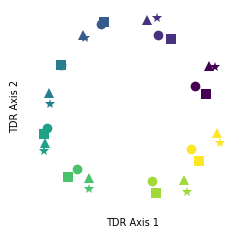

In [9]:
angle_set = np.deg2rad(np.arange(0, 360, 45))  # 8 directions
color_list = [plt.cm.brg(cond / (2 * np.pi)) for cond in angle_set]

colormap = plt.cm.viridis

color_list = [colormap(i/7) for i in range(8)]
n_cond = 8

# Create a scatter plot
fig,ax = plt.subplots(1,1,figsize=(2.5,2.5))

data_p = data_tdr[0]

s1_size = 7
s2_size = 7
s3_size = 7
s4_size = 7

s1 = '^'
s2 = 'v'
s3 = '>'
s4 = '<'

s1 = 'o'
s2 = '^'

s3 = 's'
s4 = '*'

alpha = 1

for i in range(n_cond):
    
    if i == 0:
        ax.plot(data_p[0][i,0], data_p[0][i,1],s1, markersize=s1_size, color=color_list[i],alpha=alpha,label='NF1',markeredgewidth=0)
        ax.plot(data_p[1][i,0], data_p[1][i,1],s2, markersize=s2_size, markerfacecolor=color_list[i],alpha=alpha,label='FF1',markeredgewidth=0)
        ax.plot(data_p[2][i,0], data_p[2][i,1],s3, markersize=s3_size, color=color_list[i],alpha=alpha,label='NF2',markeredgewidth=0)
        ax.plot(data_p[3][i,0], data_p[3][i,1],s4, markersize=s4_size, markerfacecolor=color_list[i],alpha=alpha,label='FF2',markeredgewidth=0)
    else:
        ax.plot(data_p[0][i,0], data_p[0][i,1],s1, markersize=s1_size, color=color_list[i],alpha=alpha,markeredgewidth=0)
        ax.plot(data_p[1][i,0], data_p[1][i,1],s2, markersize=s2_size, markerfacecolor=color_list[i],alpha=alpha,markeredgewidth=0)
        ax.plot(data_p[2][i,0], data_p[2][i,1],s3, markersize=s3_size, color=color_list[i],alpha=alpha,markeredgewidth=0)
        ax.plot(data_p[3][i,0], data_p[3][i,1],s4, markersize=s4_size, markerfacecolor=color_list[i],alpha=alpha,markeredgewidth=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#ax.set_aspect('equal')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left = False,bottom = False) 
ax.set_xlabel('TDR Axis 1', fontsize = fontsize_label)
ax.set_ylabel('TDR Axis 2', fontsize = fontsize_label)

#ax.legend(fontsize=fontsize_legend,loc='lower left',frameon = False)
fig.savefig(os.path.join(save_fig,'tdr.pdf'),dpi=300,bbox_inches='tight')

In [14]:
from sklearn.utils import resample

def bootstrap_ci(data, n_boot=1000, ci=95):
    """
    Calculate the bootstrap confidence interval.
    """
    boot_means = []
    for _ in range(n_boot):
        boot_sample = resample(data)
        boot_means.append(np.mean(boot_sample))
    
    lower = np.percentile(boot_means, (100-ci)/2)
    upper = np.percentile(boot_means, 100-(100-ci)/2)
    
    return (lower, upper)

def ci_func(values):
    """
    Compute the lower and upper confidence interval from bootstrap sampling.
    """
    ci_low, ci_high = bootstrap_ci(values)
    return ci_low, ci_high


# Plot projection on uniform shift

In [15]:
# Normalize the 'us' values
def normalize_phase_data(df):
    scale = []
    normalized_data = df.copy()
    for model in df['mn'].unique():
        model_data = df[df['mn'] == model]
        NF1_value = model_data[model_data['phase'] == 'NF1']['us'].values[0]
        FF1_value = model_data[model_data['phase'] == 'FF1']['us'].values[0]
        scaling_factor = FF1_value - NF1_value
        scale.append(scaling_factor)    
        # Apply normalization
        normalized_data.loc[normalized_data['mn'] == model, 'us'] = (
            model_data['us'] - NF1_value) / scaling_factor

    return normalized_data,scale

# Apply normalization
normalized_T,scale = normalize_phase_data(T)
normalized_T = normalized_T[normalized_T['phase'].isin(['NF2', 'FF2'])]

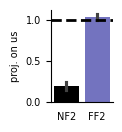

In [17]:
# Assuming T is your DataFrame

#fig,ax = plt.subplots(1,1,figsize=(1.2,1.2))
fig,ax = plt.subplots(1,1,figsize=(0.8,1.2))

#mean_nf1 = T.loc[T['phase'] == 'NF1', 'us'].mean()


sb.barplot(x='phase', y='us', data=normalized_T,palette=palette_colors,ax=ax,hue='phase',order=None,errorbar=ci_func) # ,errorbar=None



ax.axhline(1, color='black',linestyle='--',linewidth=2)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=fontsize_tick)
ax.yaxis.set_tick_params(labelsize=fontsize_tick)
ax.tick_params(bottom = False) 
ax.set_xlabel('', fontsize = fontsize_label)
ax.set_ylabel('proj. on us', fontsize = fontsize_label)
#ax.set_ylim([0,1])  # Adjust based on your data


fig.savefig(os.path.join(save_fig,'proj_on_us_0.pdf'),dpi=300,bbox_inches='tight')

# #2: Perturbation along and opposite uniform shift

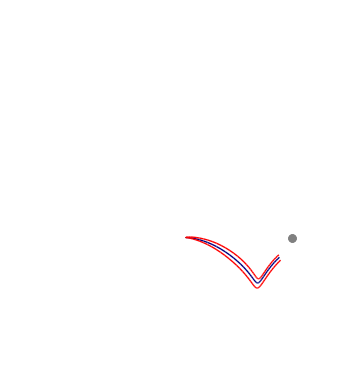

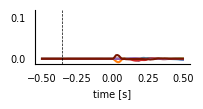

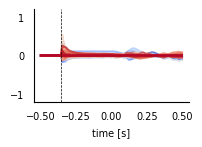

In [18]:
N_idx = 16 # 16 # time point just before the reach onset
F_idx = 59 # 25 # time point just after the reach onset

n_muscle = 6

ignore = return_ignore(folder_name,n_model) # sometimes some of cpus fail so we want to ignore those models
T = pd.DataFrame()

plot_check = True
if plot_check:
    #models = [3]
    models = [3]
else:
    models = range(n_model)

for mn in models:
    model_name = "model{:02d}".format(mn)
    if mn in ignore:
        continue

    # 0. Load weights
    weight_file,_,_= get_dir(folder_name,model_name,'NF1',0)
    W = th.load(weight_file)['fc.weight'].numpy()
    U, S, Vh = np.linalg.svd(W, full_matrices=True)
    V = Vh.T
    P = V[:,:n_muscle] # output potent
    N = V[:,n_muscle:] # output null
    
    # 1. Load data
    U = get_data(folder_name,model_name,phases,n_hidden=network_siz)

    data = []
    force = []
    for i in range(len(U)):
        data.append(np.array(U[i]['all_hidden'])[:,N_idx,:])
        force.append(np.array(U[i]['endpoint_force'])[:,F_idx,:])

    # 1 build TDR
    combined_N = np.vstack(data)
    mean_N = np.mean(combined_N, axis=0)

    X = force[0] # NF1 force 
    N = data[0]-mean_N # NF1 hidden activity

    tdr = build_tdr(X,N)


    # 2 uniform shift from NF1 to FF1
    us = np.mean(data[1]-data[0],axis=0).reshape(-1,1)
    us_orth, us_orth_norm = orth_wrt_map(us,tdr)
    #us_orth_norm = orth_wrt_map(us,P)
    #us_orth_norm = us
    #print(np.linalg.norm(us_orth_norm))
    proj_onto_us = project_onto_map(data,us_orth,remove_mean=False,mean_all=True)
    u_mean = np.mean(np.array(proj_onto_us),axis=1).ravel()
    scale = u_mean[1]-u_mean[0]

    # 3. perturb hidden
    loss_ff2_p = []
    data_p = []
    for dir in [2,-2]: # positive and negative perturbation
        d_hidden = th.from_numpy(dir*us_orth.T*1) # 0.6

        # now lets perturb or not and calculate the saving in behavior
        data_p_, loss_p = get_data(folder_name,model_name,{'NF2':[0]},[8],n_hidden=network_siz,disturb_hidden=True,t_disturb_hidden=N_idx/100,d_hidden=d_hidden,return_loss=True,catch_trial_perc=0) 
        loss_ff2_p.append(loss_p[0][loss_type].mean())
        data_p.append(data_p_)

    
    data_np, loss_np = get_data(folder_name,model_name,{'NF1':[0],'NF2':[0]},[8,8],n_hidden=network_siz,return_loss=True) 
    
    loss_ff1 = loss_np[0][loss_type].mean()
    loss_ff2_np = loss_np[1][loss_type].mean()
    

    # make a dataframe
    d = {'size':[network_siz]*4,'N':[N_idx]*4,'m':[mn]*4,'loss':[loss_ff1,loss_ff2_np,loss_ff2_p[0],loss_ff2_p[1]],'phase':['FF1','FF2','FF2+','FF2-']}
    T = pd.concat([T,pd.DataFrame(d)],ignore_index=True)


    # plot
    n_fig = 1

    if plot_check:
        kk=0

        fig,ax = plt.subplots(1,n_fig,figsize=(8,8))
        ax = [ax]

        #############
        colors = ['navy']
        cmap = ListedColormap(colors,'regions',N=1)
        plot.plot_simulations(ax[0],xy=data_np[1]['xy'][0][None],target_xy=data_np[1]['tg'][0][None],vel=None,plot_lat=False,cmap=cmap,s=25)

        colors = ['red']
        cmap = ListedColormap(colors,'regions',N=1)
        plot.plot_simulations(ax[0],xy=data_p[0][0]['xy'][0][None],target_xy=data_p[0][0]['tg'][0][None],vel=None,plot_lat=False,cmap=cmap,s=25)


        colors = ['red']
        cmap = ListedColormap(colors,'regions',N=1)
        plot.plot_simulations(ax[0],xy=data_p[1][0]['xy'][0][None],target_xy=data_p[1][0]['tg'][0][None],vel=None,plot_lat=False,cmap=cmap,s=25)
        fig.savefig(os.path.join(save_fig,'traj_FF+-.pdf'),dpi=300,bbox_inches='tight')

        #############




        ##############
        muscle_np = np.array(data_np[1]['all_action'][0,:,:])
        muscle_p = np.array(data_p[kk][0]['all_action'][0,:,:])

        fg, ax = plt.subplots(nrows=1,ncols=1,figsize=(2.,0.7))
        #ax = plot.plot_activation(ax, hidden,muscle)


        dt = 0.01
        x = np.linspace(0, np.shape(muscle_p)[0]*dt, np.shape(muscle_p)[0])-0.5

        colors = np.ones((6,4))
        colors[0,:3] = (31/255,119/255,180/255)
        colors[1,:3] = (255/255,127/255,14/255)
        colors[2,:3] = (44/255,160/255,44/255)
        colors[3,:3] = (213/255,39/255,40/255)
        colors[4,:3] = (148/255,103/255,189/255)
        colors[5,:3] = (122/255,21/255,0/255)

        labels = ['SF','SE','EF','EE','BF','BE']

        for i in range(muscle_p.shape[1]):
            ax.plot(x,muscle_p[:,i]-muscle_np[:,i],color=colors[i],label=labels[i]) # -muscle_np[:,i]
            #ax.plot(x,muscle[:,i],color=colors[i],label=labels[i])
        ax.axvline(-0.36, color='k',linestyle='--',linewidth=0.5)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(left = False,bottom = False) 
        ax.set_xlabel('time [s]', fontsize = fontsize_label)
        ax.set_ylabel('', fontsize = fontsize_label)
        ax.xaxis.set_tick_params(labelsize=fontsize_tick)
        ax.yaxis.set_tick_params(labelsize=fontsize_tick)

        ax.set_ylim([-0.012,0.12])
        fg.savefig(os.path.join(save_fig,'delta.pdf'),dpi=300,bbox_inches='tight')
        ##############


        hidden_np = np.array(data_np[1]['all_hidden'][0,:,:])
        hidden_p = np.array(data_p[kk][0]['all_hidden'][0,:,:])

        colors = plt.cm.coolwarm(np.linspace(0, 1, hidden_np.shape[1]))
        #np.random.shuffle(colors)


        fg, ax = plt.subplots(nrows=1,ncols=1,figsize=(2.,1.2))
        #ax = plot.plot_activation(ax, hidden,muscle)


        dt = 0.01
        x = np.linspace(0, np.shape(hidden_p)[0]*dt, np.shape(hidden_p)[0])-0.5


        for i in range(hidden_p.shape[1]):
            ax.plot(x,hidden_p[:,i]-hidden_np[:,i],color=colors[i],alpha=0.75) # -hidden_np[:,i]
            #ax.plot(x,muscle[:,i],color=colors[i],label=labels[i])
        ax.axvline(-0.36, color='k',linestyle='--',linewidth=0.5)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(left = False,bottom = False) 
        ax.set_xlabel('time [s]', fontsize = fontsize_label)
        ax.set_ylabel('', fontsize = fontsize_label)
        ax.xaxis.set_tick_params(labelsize=fontsize_tick)
        ax.yaxis.set_tick_params(labelsize=fontsize_tick)
        ax.set_ylim([-1.2,1.2])

        fg.savefig(os.path.join(save_fig,'delta_hidden.pdf'),dpi=300,bbox_inches='tight')

        
                

# Plot changes on the loss with or without perturbation

T-statistic: 8.184617875690822
P-value: 5.376980030038036e-10


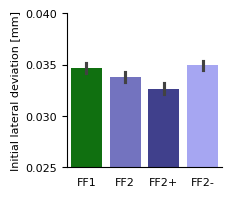

In [8]:
palette_colors2 = {'FF1':(0,0.5,0),'FF2': (0.4,0.4,0.8),'FF2+': (0.2,0.2,0.6),'FF2-': (0.6,0.6,1)}


order = ['FF1','FF2','FF2+','FF2-']

fig,ax = plt.subplots(1,1,figsize=(2,2))
# Plot for T_pos on the first subplot
sb.barplot(x='phase', y='loss', data=T, hue='phase', ax=ax,palette=palette_colors2,order=order,width=0.8)



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0.025,0.04])
ax.set_yticks([0.025,0.03,0.035,0.04])
ax.xaxis.set_tick_params(labelsize=fontsize_tick)
ax.yaxis.set_tick_params(labelsize=fontsize_tick)
ax.tick_params(bottom = False) 
ax.set_xlabel('', fontsize = fontsize_label)
ax.set_ylabel('Initial lateral deviation [mm]', fontsize = fontsize_label)



fig.savefig(os.path.join(save_fig,'FF2_perturb_lat0.pdf'),dpi=300,bbox_inches='tight')


L = T.pivot_table(index='m',columns='phase',values='loss')
t_statistic, p_value = stats.ttest_rel(L['FF2'],L['FF2+'])
print("T-statistic:", t_statistic)
print("P-value:", p_value)

In [10]:
T

,size,N,m,loss,phase
0,128,16,0,0.034499,FF1
1,128,16,0,0.034335,FF2
2,128,16,0,0.033811,FF2+
3,128,16,0,0.034748,FF2-
4,128,16,1,0.033461,FF1
...,...,...,...,...,...
155,128,16,38,0.032814,FF2-
156,128,16,39,0.032156,FF1
157,128,16,39,0.031634,FF2
158,128,16,39,0.029345,FF2+


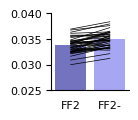

In [15]:
fig,ax = plt.subplots(1,1,figsize=(1.,1))
palette_colors2 = {'FF1':(0,0.5,0),'FF2': (0.4,0.4,0.8),'FF2+': (0.2,0.2,0.6),'FF2-': (0.6,0.6,1)}


p1='FF2'
p2='FF2-'

D = T[(T['phase'].isin([p1,p2]))]



order = None
# Plot for T_pos on the first subplot
sb.barplot(x='phase', y='loss', data=D, hue='phase', ax=ax,palette=palette_colors2,order=None,width=0.8,errorbar=None) 

for group_id, group_data in D.groupby('m'):
    p1_dat = group_data[group_data['phase'] == p1]['loss'].values[0]
    p2_dat = group_data[group_data['phase'] == p2]['loss'].values[0]

    ax.plot([p1,p2], [p1_dat, p2_dat], color='k',linewidth=0.5)



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0.025,0.04])
#ax.set_yticks([0.025,0.03,0.035,0.04])

ax.xaxis.set_tick_params(labelsize=fontsize_tick)
ax.yaxis.set_tick_params(labelsize=fontsize_tick)

ax.tick_params(bottom = False)
ax.set_xlabel('', fontsize = fontsize_label)
ax.set_ylabel('', fontsize = fontsize_label)
 

if p2=='FF2+':
    fig.savefig(os.path.join(save_fig,'FF2_perturb_lat_pos.pdf'),dpi=300,bbox_inches='tight')
else:
    fig.savefig(os.path.join(save_fig,'FF2_perturb_lat_neg.pdf'),dpi=300,bbox_inches='tight')


#fig.savefig(os.path.join(save_fig,'FF2_perturb_latneg.pdf'),dpi=300,bbox_inches='tight')
# Display the plot
#plt.tight_layout()  # Adjust the layout
#plt.show()


# L = T.pivot_table(index='m',columns='phase',values='loss')
# t_statistic, p_value = stats.ttest_rel(L['ff2'],L['ff2_p'])
# print("T-statistic:", t_statistic)
# print("P-value:", p_value)